In [1]:
import numpy as np
from ase import Atoms
from ase.build import molecule
from ase.calculators.tip4p import TIP4P
np.random.seed(42)

In [2]:
atoms = Atoms()
atoms.cell = (20, 20, 20)

h2o = molecule('H2O')
h2o.rotate('z', 'x')
h2o.rotate('x', 'y')
h2o.translate([2,2,0])
translate_vectors = [[i, j, 0] for i in [0,4,8,12,16] for j in [0,4,8,12,16]]

for i, vec in enumerate(translate_vectors):
    add = h2o.copy()
    add.set_tags([i]*len(add))
    add.translate(vec)
    atoms += add
initial = atoms.copy()
initial.pbc = True

In [3]:
# from ase.visualize import view
# view(initial)

In [4]:
import sys
sys.path.append('../')
from asetil.monte_carlo.monte_carlo import MonteCarlo
from asetil.monte_carlo.sampler import TranslateSampler, XYZAxesRotateSampler
from asetil.monte_carlo.tag_selector import RandomTagSelector
from asetil.monte_carlo.sampler_selector import RandomSamplerSelector
from asetil.monte_carlo.logger import MCPrintLogger, MCPFileLogger, MCInMemoryLogger

In [5]:
d = 1e-8
translate_sampler = TranslateSampler(tag_selector=RandomTagSelector(), x_range=(-0.5, 0.5), y_range=(-0.5, 0.5), z_range=(-d, d))
rotate_sampler = XYZAxesRotateSampler(tag_selector=RandomTagSelector(), x_axis_range=(-d, d), y_axis_range=(-d, d), z_axis_range=(-90,90))

sampler_selector = RandomSamplerSelector()
sampler_selector.add_sampler(translate_sampler, weight=1)
sampler_selector.add_sampler(rotate_sampler, weight=1)

loggers = [
    MCPrintLogger(log_interval=100),
    MCPFileLogger(log_interval=100, out_file='example1.log', force_overwrite=True),
    MCInMemoryLogger(log_interval=10)
]
mc = MonteCarlo(temperature=200, max_iter=5000, sampler_selector=sampler_selector, loggers=loggers)
initial.calc = TIP4P()
ret = mc.run(initial)
ret.wrap()

initializing loggers
 iteration,    sampler.name, latest_accepted_energy,    delta_e,   acceptability,  is_accepted
         0,       Translate,              -0.449936,   0.008580,        0.607857,         True
       100,       Translate,              -2.153263,  -0.006603,        1.000000,         True
       200,       XYZRotate,              -3.105047,   0.090920,        0.005116,        False
       300,       Translate,              -3.414222,   0.094041,        0.004269,        False
       400,       XYZRotate,              -3.791377,   0.247813,        0.000001,        False
       500,       XYZRotate,              -4.265613,  -0.027417,        1.000000,         True
       600,       XYZRotate,              -4.638411,   0.114561,        0.001298,        False
       700,       XYZRotate,              -4.869146,   0.060162,        0.030478,        False
       800,       Translate,              -5.095975,   0.001165,        0.934660,         True
       900,       Translate, 

In [6]:
# from ase.visualize import view
# view(ret)

Text(0.5, 1.0, 'Monte Carlo simulation results')

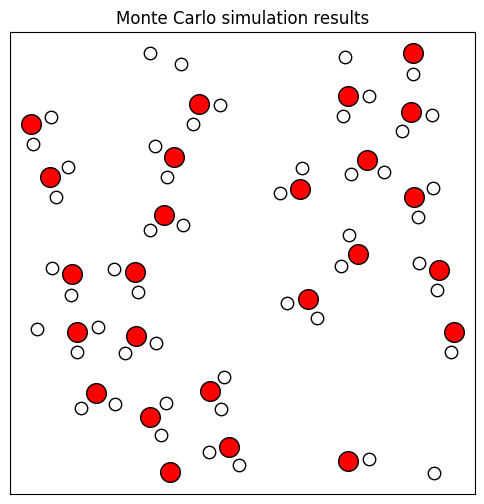

In [7]:
import matplotlib.pyplot as plt

os = ret[np.array(ret.get_chemical_symbols()) == 'O']
hs = ret[np.array(ret.get_chemical_symbols()) == 'H']

o_pos = os.get_positions()
h_pos = hs.get_positions()

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(o_pos[:,0], o_pos[:,1], c='r', edgecolors='k', linewidth=1, s=200)
ax.scatter(h_pos[:,0], h_pos[:,1], c='w', edgecolors='k', linewidth=1, s=80)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('Monte Carlo simulation results')

In [8]:
import pandas as pd
log, columns = loggers[2].get_log(with_columns=True)
df = pd.DataFrame(log, columns=columns)
df

C:\Users\User\AppData\Local\Temp\ipykernel_8860\1455353790.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,iteration,sampler.name,latest_accepted_energy,delta_e,acceptability,is_accepted
0,0,Translate,-0.449936,0.008580,6.078572e-01,True
1,10,Translate,-0.664503,0.017606,3.600328e-01,True
2,20,XYZRotate,-1.031376,-0.109574,1.000000e+00,True
3,30,Translate,-1.266411,-0.010016,1.000000e+00,True
4,40,Translate,-1.361159,-0.018588,1.000000e+00,True
...,...,...,...,...,...,...
495,4950,Translate,-6.260050,1.080724,5.847231e-28,False
496,4960,XYZRotate,-6.260050,0.156067,1.167576e-04,False
497,4970,Translate,-6.239263,0.006215,6.972591e-01,True
498,4980,XYZRotate,-6.301325,0.038776,1.054114e-01,False


Text(0, 0.5, 'latest accepted energy / eV')

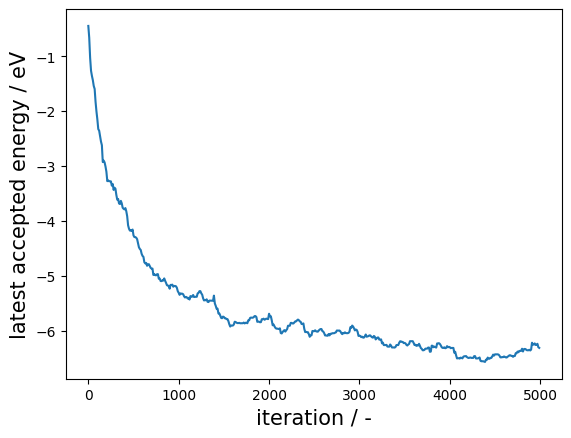

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df['iteration'], df['latest_accepted_energy'])
ax.set_xlabel('iteration / -', fontsize=15)
ax.set_ylabel('latest accepted energy / eV', fontsize=15)